## Random Forest

**Random Forest** is an ensemble technique which combines many randomly generated decision trees to make a powerful ML model. Algorithm for making a **Random Forest** is like this:
1. For b = 1 to B:
    a. Draw a bootstrap sample **$Z^{*}$** from training data. (Bootstrap sample is sample with replacement).
    b. Grow a random-forest tree $T_b$ to the bootstrapped data by selecting $m$ random variables from $p$ features at each split point.
2. Output the ensemble of trees.

To make prediction for **Regression** trees we do
$f(x) = \frac{1}{B}\sum_{b=1}^B T_b(x)$

For **Classification** we take the majority vote. In the notebook below we will use Sklearns **Random Forest** trees.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Make the sheet width 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>" ))

In [2]:
#Load california housing dataset
from sklearn import datasets
california_data = datasets.fetch_california_housing()
df_cali = pd.DataFrame(california_data.data, columns=california_data.feature_names)
df_cali['target'] = pd.Series(california_data.target)

In [3]:
df_cali.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
df_cali.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


There are 8 features and 20640 entries. Lets plot the data.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_cali.drop('target', axis=1), df_cali['target'].values, test_size=0.10, random_state=1)

print(f"Size of test set = {y_test.shape[0]}")
print(f"Size of train set = {y_train.shape[0]}")

Size of test set = 2064
Size of train set = 18576


In [6]:
#Lets first standardize the X
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

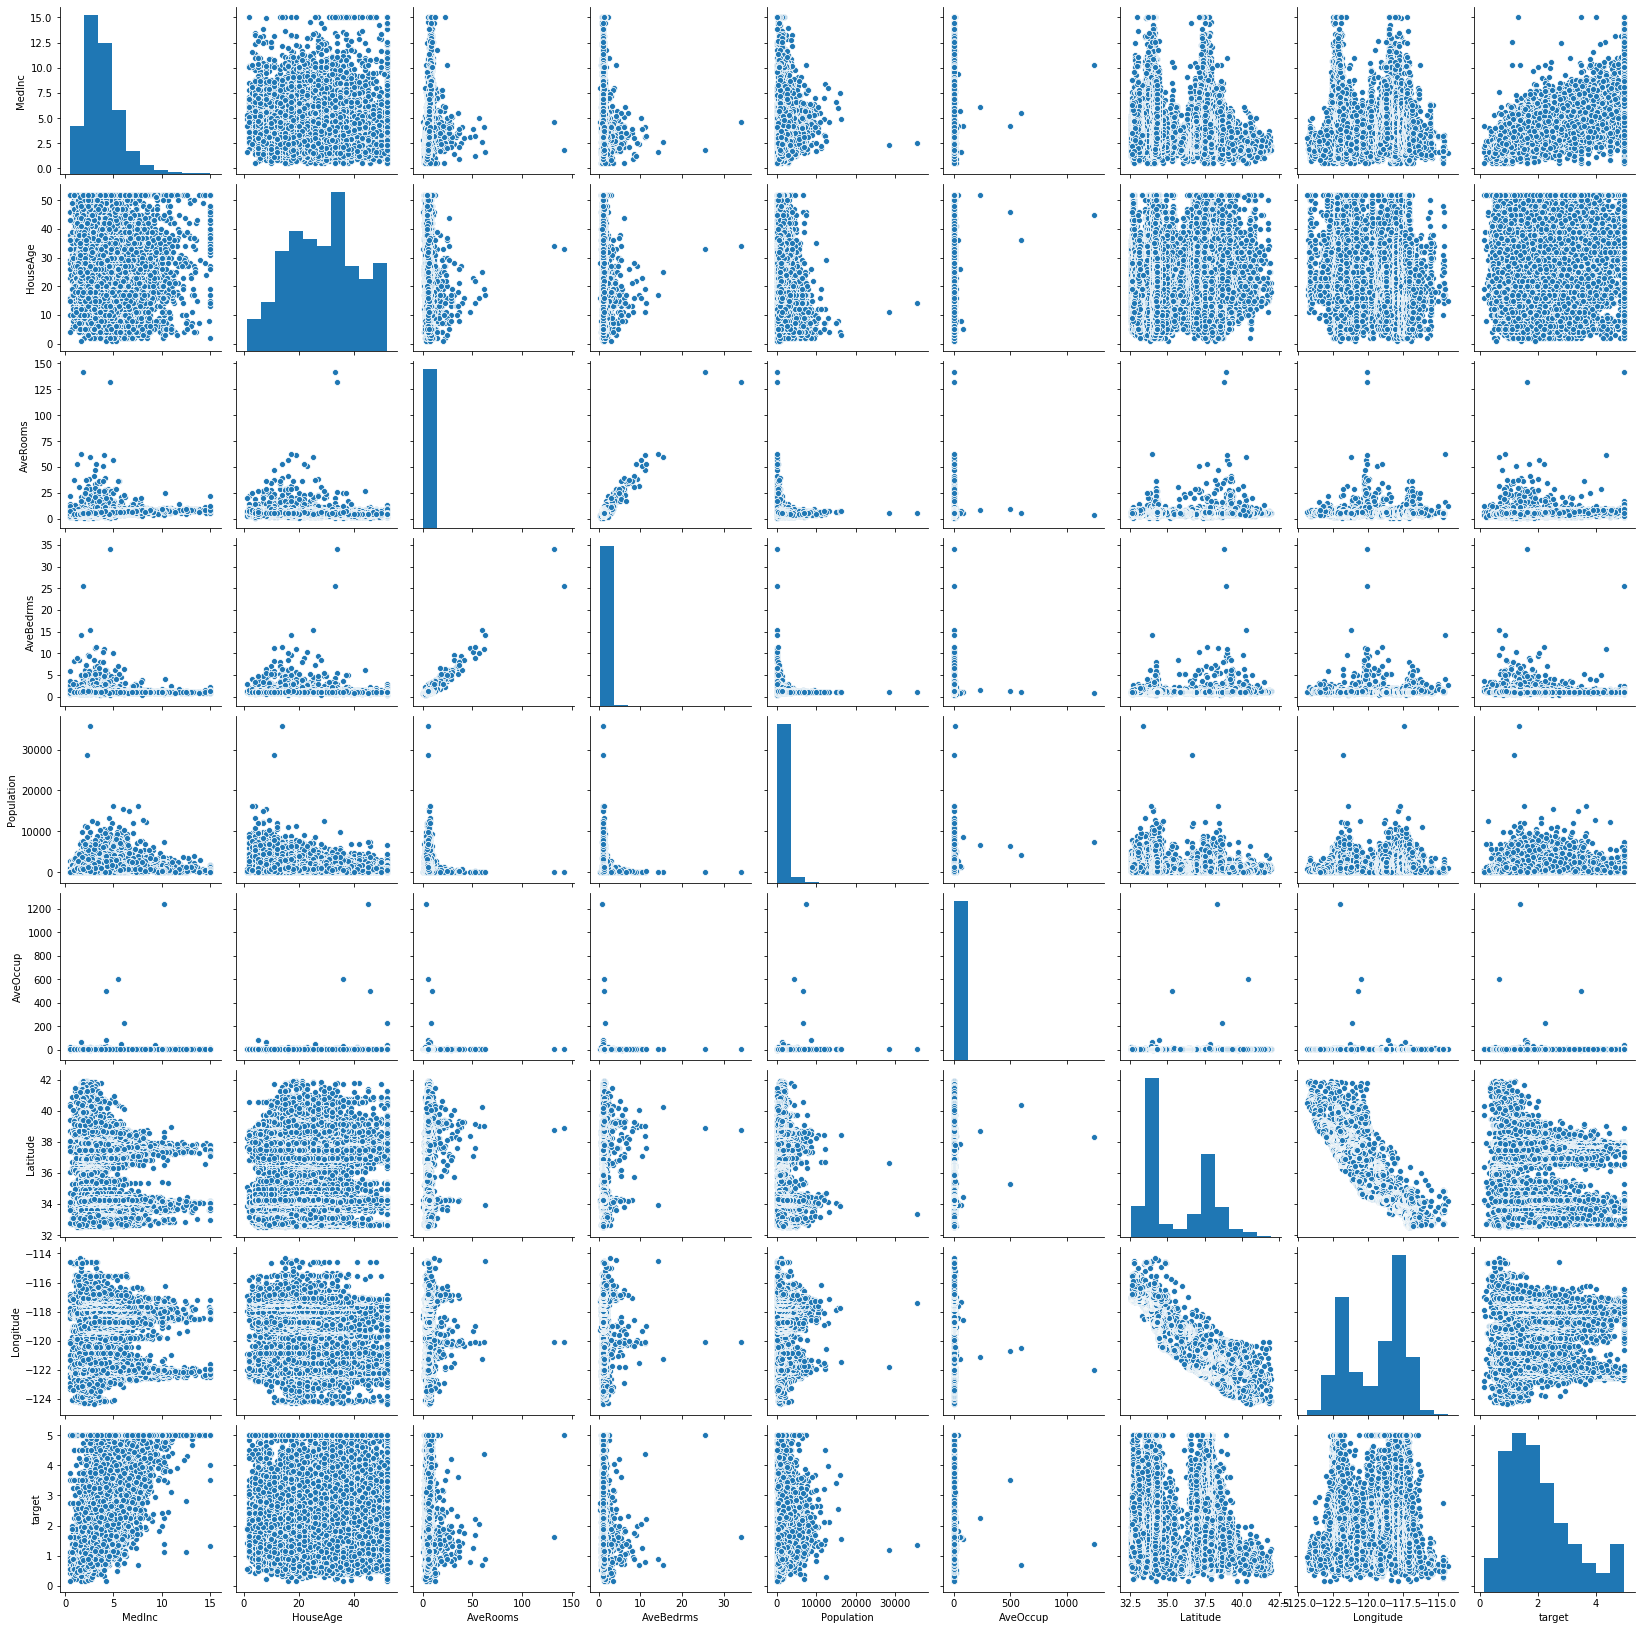

In [7]:
import seaborn as sns
sns.pairplot(df_cali)

In [8]:
#Now lets fit a linear model to the data
import statsmodels.api as sm
X_with_intercept = sm.add_constant(X_train_std, prepend=False)
colnames = np.append(california_data.feature_names, 'intercept')
train_data = pd.DataFrame(X_with_intercept, 
                          columns=colnames)
train_data['target'] =  y_train
mod = sm.OLS(train_data.target,train_data.drop('target', axis=1))
res = mod.fit()
print(res.summary())

X_test_with_intercept = sm.add_constant(X_test_std, prepend=False)
y_test_pred = res.predict(X_test_with_intercept)
y_mean = np.mean(y_test)
TSS = np.sum(np.square(y_test - y_mean))
RSS = np.sum(np.square(y_test - y_test_pred))
score = (1 - RSS/TSS)
print(f"Test set score { score :.3}")

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     3582.
Date:                Mon, 13 Jul 2020   Prob (F-statistic):               0.00
Time:                        17:24:14   Log-Likelihood:                -20337.
No. Observations:               18576   AIC:                         4.069e+04
Df Residuals:                   18567   BIC:                         4.076e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MedInc         0.8316      0.008     99.364      0.0

We can see from the linear model that everything except population is a significant predictor.

In [9]:
#One useful function for plotting data
def binBinPlot(x, y, nbins):
    df = pd.DataFrame({'x':x , 'y': y})
    cuts = np.percentile(x, np.linspace(0, 1, nbins+1)*100)
    cuts = np.unique(cuts)
    df['bins'] = pd.cut(x, cuts)
    g = df.groupby('bins').mean()
    plt.figure(figsize=(10,10))
    plt.plot(g['x'], g['y'], 'ro')

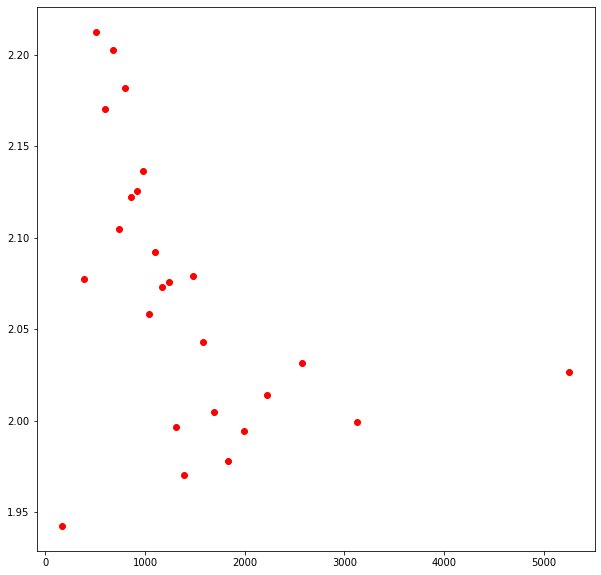

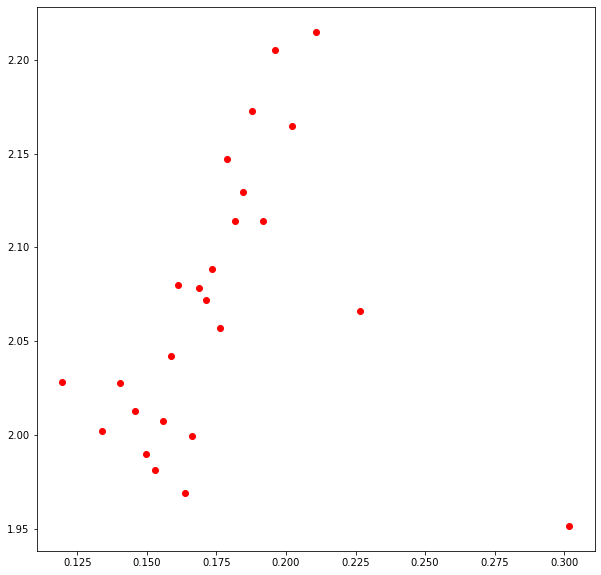

In [10]:
#Lets plot population vs target
binBinPlot(df_cali['Population'], df_cali['target'], 25)
binBinPlot(1/np.sqrt(np.sqrt(df_cali['Population'])), df_cali['target'], 25)

#From the plots below we can see there is more of a non linear relationship between target and population

In [11]:
#Now lets apply decision tree model
from sklearn import tree
clf = tree.DecisionTreeRegressor(min_samples_split=5)
clf = clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=0.983
Test score=0.653


We can see from the above test and train errors that the decision tree over fitted the data.

In [12]:
#Lets apply cross validation to find a good number for min_samples_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
pipe_tree = make_pipeline(StandardScaler(),
                       tree.DecisionTreeRegressor())
param_range = np.array([2,5,10,20,50])
param_grid = [{'decisiontreeregressor__min_samples_split': param_range}]
gs = GridSearchCV(estimator=pipe_tree, param_grid=param_grid, cv=10, refit=True)
gs = gs.fit(X_train, y_train)

print(f"Best score = {gs.best_score_:.3}")
print(gs.best_params_)

#Fit the model with best_params on total train set
clf = tree.DecisionTreeRegressor(min_samples_split=50)
clf.fit(X_train_std, y_train)
#Evaluate on test set
print(f"Test score {clf.score(X_test_std, y_test):.3}")

Best score = 0.707
{'decisiontreeregressor__min_samples_split': 50}
Test score 0.718


With better cross validation and selection of parameters of the regression tree we got a little better result. But still not very impressive. Now lets apply random forest to the problem.

In [13]:
#Lets apply cross validation to find a good number for min_samples_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
pipe_forest = make_pipeline(StandardScaler(),
                       RandomForestRegressor())

param_range = np.array([10,50,100,200,500])
param_grid = [{'randomforestregressor__n_estimators': param_range,
               'randomforestregressor__min_samples_split': np.array([2,5,10,20,50])}]
gs = GridSearchCV(estimator=pipe_forest, param_grid=param_grid, cv=10, refit=True)
gs = gs.fit(X_train, y_train)

print(f"Best score = {gs.best_score_:.3}")
print(gs.best_params_)

Best score = 0.812
{'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 500}


In [14]:
#Fit the model with best_params on total train set
clf = RandomForestRegressor(n_estimators=500, min_samples_split=2)
clf.fit(X_train_std, y_train)
#Evaluate on test set
print(f"Test score {clf.score(X_test_std, y_test):.3}")

Test score 0.816


We got test score of 81.6% that is quite a bit improvement from linear model of 60.1%.

#### Lets plot the train, cross validation, out of bag score and test score as a function of forest size.

In [15]:
#Fit the model with best_params on total train set
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
forestSize = [25, 50, 100, 200, 500]
pipelines = dict()
for fsz in forestSize:
    pipelines[fsz] = make_pipeline(StandardScaler(),
                RandomForestRegressor(n_estimators=fsz, min_samples_split=2, oob_score=True))

results = dict()
fold = 0
for train_index, cv_index in kf.split(X_train.values):
    X_cv_train, X_cv_test = X_train.values[train_index], X_train.values[cv_index]
    y_cv_train, y_cv_test = y_train[train_index], y_train[cv_index]
    results[fold] = dict()
    for (key, p) in pipelines.items():
        print(f"Fold {fold} calculating for forest of size {key}")
        p.fit(X_cv_train, y_cv_train)
        results[fold][key] = {'TrainScore' : p.score(X_cv_train, y_cv_train), 
                            'OOBScore' : p.steps[1][1].oob_score_,
                            'CVScore': p.score(X_cv_test, y_cv_test)}
    fold += 1

Fold 0 calculating for forest of size 25
Fold 0 calculating for forest of size 50
Fold 0 calculating for forest of size 100
Fold 0 calculating for forest of size 200
Fold 0 calculating for forest of size 500
Fold 1 calculating for forest of size 25
Fold 1 calculating for forest of size 50
Fold 1 calculating for forest of size 100
Fold 1 calculating for forest of size 200
Fold 1 calculating for forest of size 500
Fold 2 calculating for forest of size 25


/Users/manan/opt/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Fold 2 calculating for forest of size 50
Fold 2 calculating for forest of size 100
Fold 2 calculating for forest of size 200
Fold 2 calculating for forest of size 500
Fold 3 calculating for forest of size 25


/Users/manan/opt/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Fold 3 calculating for forest of size 50
Fold 3 calculating for forest of size 100
Fold 3 calculating for forest of size 200
Fold 3 calculating for forest of size 500
Fold 4 calculating for forest of size 25
Fold 4 calculating for forest of size 50
Fold 4 calculating for forest of size 100
Fold 4 calculating for forest of size 200
Fold 4 calculating for forest of size 500
Fold 5 calculating for forest of size 25
Fold 5 calculating for forest of size 50
Fold 5 calculating for forest of size 100
Fold 5 calculating for forest of size 200
Fold 5 calculating for forest of size 500
Fold 6 calculating for forest of size 25
Fold 6 calculating for forest of size 50
Fold 6 calculating for forest of size 100
Fold 6 calculating for forest of size 200
Fold 6 calculating for forest of size 500
Fold 7 calculating for forest of size 25
Fold 7 calculating for forest of size 50
Fold 7 calculating for forest of size 100
Fold 7 calculating for forest of size 200
Fold 7 calculating for forest of size 500
F

/Users/manan/opt/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Fold 8 calculating for forest of size 50
Fold 8 calculating for forest of size 100
Fold 8 calculating for forest of size 200
Fold 8 calculating for forest of size 500
Fold 9 calculating for forest of size 25
Fold 9 calculating for forest of size 50
Fold 9 calculating for forest of size 100
Fold 9 calculating for forest of size 200
Fold 9 calculating for forest of size 500


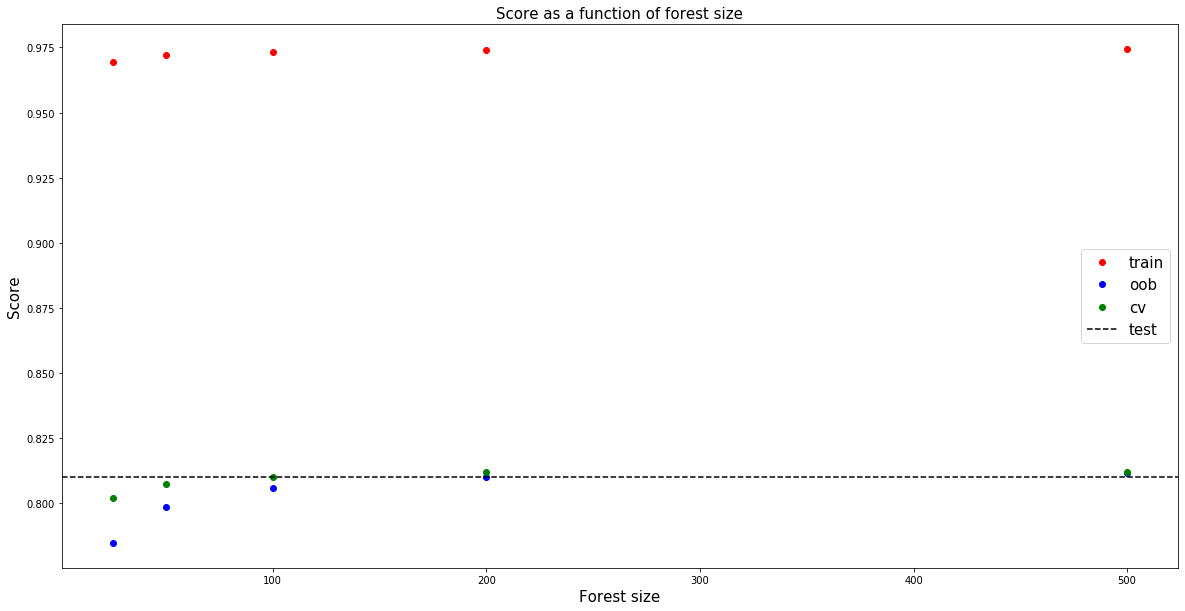

In [16]:
trainScore = []
OOBScore = []
CVScore = []
for s in forestSize:
    train = [ v[s]['TrainScore'] for (k,v) in results.items()]
    trainScore.append(np.mean(train))
    oob = [ v[s]['OOBScore'] for (k,v) in results.items()]
    OOBScore.append(np.mean(oob))
    cv = [v[s]['CVScore'] for (k,v) in results.items()]
    CVScore.append(np.mean(cv))
plt.figure(figsize=(20,10))
plt.title('Score as a function of forest size', fontsize=15)
plt.plot(forestSize, trainScore, 'ro', label='train')
plt.plot(forestSize, OOBScore, 'bo', label='oob')
plt.plot(forestSize, CVScore, 'go', label='cv')
plt.xlabel('Forest size', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.axhline(y=0.81,linestyle='--', color='black', label='test')
plt.legend(fontsize=15)

#### we can see from the plot above that oob error and cv error are very good estimate of test error

#### Lets implement random forest from scratch
We will build on decision tree implementation here, in Random forest we split randomly on Xs

In [17]:
#Implement regression decision tree
#This implementation is same as 

from collections import Counter
class RF:
    """
    Implementation of a decision tree for regression
    """
    class Node:
        xIndex = None
        xSplitPoint = None
        value = None
        leftNode = None
        rightNode = None
        mse = None
        nSamples = None
        
    trees = list()
    def __init__(self, minDataPoints=2, nTrees=100, random_state=1):
        np.random.seed(random_state)
        self.minDataPoints = minDataPoints
        self.nTrees = nTrees
    
    def fit(self, x, y):
        for n in range(self.nTrees):
            print(f"Calculating tree {n+1}")
            root = RF.Node()
            #Create a boot strap sample
            Z = np.random.choice(x.shape[0], x.shape[0], replace=True)
            x_boot = x[Z,:]
            y_boot = y[Z]
            self._split(x_boot, y_boot, root, self.minDataPoints)
            self.trees.append(root)
           
    def predict(self, x):
        predictions = []
        for t in self.trees:
            pred = RF._predict(t, x)
            predictions.append(pred)
        return sum(predictions) / len(self.trees)
        
    def print(self):
        RF._print(self.root,"")
        
    @staticmethod 
    def _predict(node, x):
        if (node.leftNode == None) :
            return node.value
        elif (x[node.xIndex] <= node.xSplitPoint):
            return RF._predict(node.leftNode, x)
        else:
            return RF._predict(node.rightNode, x)
    
    @staticmethod
    def _print(node, indent):
        if (node.leftNode == None) :
            print(f"{indent}value={node.value:.3}, mse={node.mse:.3}, nsamples={node.nSamples}")
        else:
            print(f"{indent}x[{node.xIndex}]={node.xSplitPoint:.3}, value={node.value:.3}, mse={node.mse:.3}, nsamples={node.nSamples}")
            indent += " "
            RF._print(node.leftNode, indent)
            RF._print(node.rightNode, indent)
        
    
    @staticmethod
    def _split(x, y, node, minDataPoints):
        node.value = np.mean(y)
        node.mse = np.sum(np.square(y - node.value))/y.shape[0]     
        node.nSamples = y.shape[0]
        
        if (y.shape[0]  < minDataPoints):
            return
        else:
            (x_index, x_point) = RF._findBestSplit(x, y)
            y_left = y[x[:,x_index] <= x_point]
            y_right = y[x[:,x_index] > x_point]
            x_left = x[x[:,x_index] <= x_point]
            x_right = x[x[:,x_index] > x_point]
            if (y_left.shape[0] == 0) or (y_right.shape[0] == 0):
                return
            node.xIndex = x_index
            node.xSplitPoint = x_point
            node.leftNode = RF.Node()
            node.rightNode = RF.Node()
            RF._split(x_left, y_left, node.leftNode, minDataPoints)
            RF._split(x_right, y_right, node.rightNode, minDataPoints)
    
    @staticmethod
    def _findBestSplit(x, y):
        nx = x.shape[1]
        bestXIndex = -1
        bestSplitPoint = -1
        bestLoss = float("inf")
        #Randomly select m xs for trying
        m = int(np.sqrt(x.shape[1]))
        xToTry = np.random.choice(x.shape[1], m, replace=False)
        for i in range(nx):
            if i not in xToTry:
                #If i is not in xToTry then continue
                continue
            xSortNdx = np.argsort(x[:,i])
            xSort = x[xSortNdx,i]
            ySort = y[xSortNdx]
            z = RF._calculateRegressionLoss( xSort, ySort )
            l = np.min(z)
            if l < bestLoss:
                bestSplitPoint = (xSort[np.argmin(z)] + xSort[np.argmin(z)+1])/2.0
                bestLoss = l
                bestXIndex = i
            
        return (bestXIndex, bestSplitPoint)
    
    @staticmethod
    def _calculateRegressionLoss(x, y):
        """
        Given a sorted x returns a vector of Loss if split by x_i
        Note this code can be optimized significantly but here we are writing for understanding 
        not speed
        """
        N = x.shape[0]
        l = np.zeros(N-1)
        for i in range(1, N):
            mean1 = np.mean(y[0:i])
            mean2 = np.mean(y[i:])
            l1 = np.sum(np.square(y[0:i] - mean1))
            l2 = np.sum(np.square(y[i:] - mean2))
            l[i-1] = l1 + l2
        return l

In [18]:
#Fit the random forest
rf = RF(nTrees=100)
rf.fit(X_train_std,y_train)
y_pred = []
print("Predicting...")
for xi in X_test_std:
    y_pred.append(rf.predict(xi))

y_pred = np.array(y_pred)
from sklearn.metrics import r2_score
score = r2_score(y_test, y_pred)
print(f"Random forest test score = {score: .4}")

Calculating tree 1
Calculating tree 2
Calculating tree 3
Calculating tree 4
Calculating tree 5
Calculating tree 6
Calculating tree 7
Calculating tree 8
Calculating tree 9
Calculating tree 10
Calculating tree 11
Calculating tree 12
Calculating tree 13
Calculating tree 14
Calculating tree 15
Calculating tree 16
Calculating tree 17
Calculating tree 18
Calculating tree 19
Calculating tree 20
Calculating tree 21
Calculating tree 22
Calculating tree 23
Calculating tree 24
Calculating tree 25
Calculating tree 26
Calculating tree 27
Calculating tree 28
Calculating tree 29
Calculating tree 30
Calculating tree 31
Calculating tree 32
Calculating tree 33
Calculating tree 34
Calculating tree 35
Calculating tree 36
Calculating tree 37
Calculating tree 38
Calculating tree 39
Calculating tree 40
Calculating tree 41
Calculating tree 42
Calculating tree 43
Calculating tree 44
Calculating tree 45
Calculating tree 46
Calculating tree 47
Calculating tree 48
Calculating tree 49
Calculating tree 50
Calculati

#### Our implementation of Random Forest gives very similar performance as Sklearn :-)